<a href="https://colab.research.google.com/github/JackyChen2T2/REScipe/blob/main/REScipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# for loading google drive files
from google.colab import drive
drive.mount('/content/drive')

# for data cleaning
import pandas as pd
import numpy as np

# for tokenizing english words and applying GloVe representation
import spacy
!python -m spacy download en_core_web_sm
import gensim
from gensim import corpora, models
# for improving plural to singular lemmatization
import inflect
p = inflect.engine()

# for visualizing frequency in order
import operator
import matplotlib.pyplot as plt

# for measuring training time 
import time

# for logging LDA model convergence
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [2]:
# flags
XLSX_PATH = '/content/drive/My Drive/Colab Notebooks/Project_REScipe/data/total_data.xlsx'      # copy the path of the xlsx file in Path in Google Colab menu
XLSX_COLUMN = ['rand_int_0', 'name', 'url', 'rand_int_1', 'size', 'ingredient', 'recipe', 'url_ext']
ALL_DATA = False

===================== A =====================

This section loads the excel file(.xlsx) into a Pandas Dataframe.

（if total_name.csv already exists, do not run this section）


In [ ]:
# load the xlsx file from Google Drive to a Pandas Dataframe
xlsx_total_data = pd.read_excel(XLSX_PATH, header=None, names=XLSX_COLUMN)

print(xlsx_total_data)

       rand_int_0  ... url_ext
0               0  ...   70006
1               1  ...   70012
2               2  ...   70014
3               3  ...   70019
4               4  ...   70032
...           ...  ...     ...
46899          21  ...  269894
46900          22  ...  269895
46901          23  ...  269896
46902          24  ...  269898
46903          25  ...  269899

[46904 rows x 8 columns]


===================== B =====================

This section saves recipe names (index 'name') from the Pandas Dataframe to a csv file in the same Google Drive folder.

This file (total_name.csv) is a look-up dictionary for debugging topic modeling and LDA.

（if total_name.csv already exists, do not run this section）

In [ ]:
# extract the column of 'name' from the Pandas Dataframe
csv_name = xlsx_total_data[['name']]
# add an additional index column, in case that tokenization or GloVe representation removes certain recipes
csv_name['index'] = csv_name.index

csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/total_name.csv'
csv_name.to_csv(csv_path, index=False)

print(csv_name)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                                       name  index
0                    Whole Wheat Pita Bread      0
1              Baked Mac and Cheese for One      1
2                             Blonde Bobbie      2
3                                Egg Butter      3
4                                Beer Pizza      4
...                                     ...    ...
46899                     Love Potion No. 9  46899
46900      Pimiento Cheese and Tomato Bites  46900
46901  Wolfgang Puck's Cheeseburger Sliders  46901
46902    Instant PotÂ® Sweet Baby Back Ribs  46902
46903           Instant PotÂ® Zuppa Toscana  46903

[46904 rows x 2 columns]


===================== C =====================

This section loads total_name.csv and saves a tokenized version of this csv back.

This file (token_name.csv) is used for topic modeling with LDA, and GloVe representation (optional).

（if token_name.csv already exists, do not run this section. This section will take approximately 15 minutes to run.）

In [ ]:
csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/total_name.csv'
csv_name = pd.read_csv(csv_path)

# load spaCy english nlp model
nlp = spacy.load('en_core_web_sm')

# tokenize, remove non-ascii chars, lemmatize, remove stop words (safe actions)
list_token_name = []
for i, row in csv_name.iterrows():
  token_name = []
  # tokenize and lemmatize
  for word in nlp(row['name']):
    # remove non-ascii chars
    if all(ord(char) < 128 for char in word.lemma_):
      text = word.text
      lemma = word.lemma_.lower()
    else:
      text = word.text.encode('ascii','ignore').decode()
      lemma = word.lemma_.lower().encode('ascii','ignore').decode()
    # remove stop words
    if (len(text) > 2) and (len(lemma) > 2) and (word.is_stop == False):
      if p.singular_noun(lemma) != False:
        token_name.append(p.singular_noun(lemma))
      else:
        token_name.append(lemma)
  if token_name != []:
    list_token_name.append([token_name, row['index']])
  else:
    print(row['index'], row['name'],'removed by tokenization.', sep='\t')
  if i % 1000 == 0:
    print('Tokenizing:', i, '~', min(i+1000, csv_name.shape[0]))

csv_token_name = pd.DataFrame(list_token_name, columns=['token_name', 'index'])
print(csv_token_name)

csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/token_name.csv'
csv_token_name.to_csv(csv_path, index=False)

Tokenizing: 0 ~ 1000
Tokenizing: 1000 ~ 2000
Tokenizing: 2000 ~ 3000
Tokenizing: 3000 ~ 4000
Tokenizing: 4000 ~ 5000
Tokenizing: 5000 ~ 6000
Tokenizing: 6000 ~ 7000
6050	CB	removed by tokenization.
Tokenizing: 7000 ~ 8000
Tokenizing: 8000 ~ 9000
Tokenizing: 9000 ~ 10000
Tokenizing: 10000 ~ 11000
Tokenizing: 11000 ~ 12000
Tokenizing: 12000 ~ 13000
Tokenizing: 13000 ~ 14000
Tokenizing: 14000 ~ 15000
Tokenizing: 15000 ~ 16000
Tokenizing: 16000 ~ 17000
Tokenizing: 17000 ~ 18000
Tokenizing: 18000 ~ 19000
Tokenizing: 19000 ~ 20000
Tokenizing: 20000 ~ 21000
Tokenizing: 21000 ~ 22000
Tokenizing: 22000 ~ 23000
Tokenizing: 23000 ~ 24000
Tokenizing: 24000 ~ 25000
Tokenizing: 25000 ~ 26000
Tokenizing: 26000 ~ 27000
26118	7 and 7	removed by tokenization.
26120	7 and 7 and 7	removed by tokenization.
Tokenizing: 27000 ~ 28000
Tokenizing: 28000 ~ 29000
Tokenizing: 29000 ~ 30000
Tokenizing: 30000 ~ 31000
Tokenizing: 31000 ~ 32000
Tokenizing: 32000 ~ 33000
Tokenizing: 33000 ~ 34000
Tokenizing: 34000 ~ 3

Reading and copying: 0 ~ 10000
Reading and copying: 10000 ~ 20000
Reading and copying: 20000 ~ 30000
Reading and copying: 30000 ~ 40000
Reading and copying: 40000 ~ 46900
# of Recipe:	 46901
# of Word:	 174223
unique Tokens:	 8811

infrequent Tokens:	 4455
Removing infrequent tokens: 0 ~ 1000
!	13	['channel', 'marker']	removed due to lack of common tokens.
!	43	['hamantashen']	removed due to lack of common tokens.
!	139	['mangu']	removed due to lack of common tokens.
!	142	['karithopita']	removed due to lack of common tokens.
!	144	['dolma']	removed due to lack of common tokens.
!	181	['tako', 'poki']	removed due to lack of common tokens.
!	356	['finadeni']	removed due to lack of common tokens.
!	442	['ghoraiybah']	removed due to lack of common tokens.
!	448	['biriyani']	removed due to lack of common tokens.
!	532	['turffaloaf']	removed due to lack of common tokens.
!	661	['borboleta']	removed due to lack of common tokens.
!	764	['cranachan']	removed due to lack of common tokens.
!	776

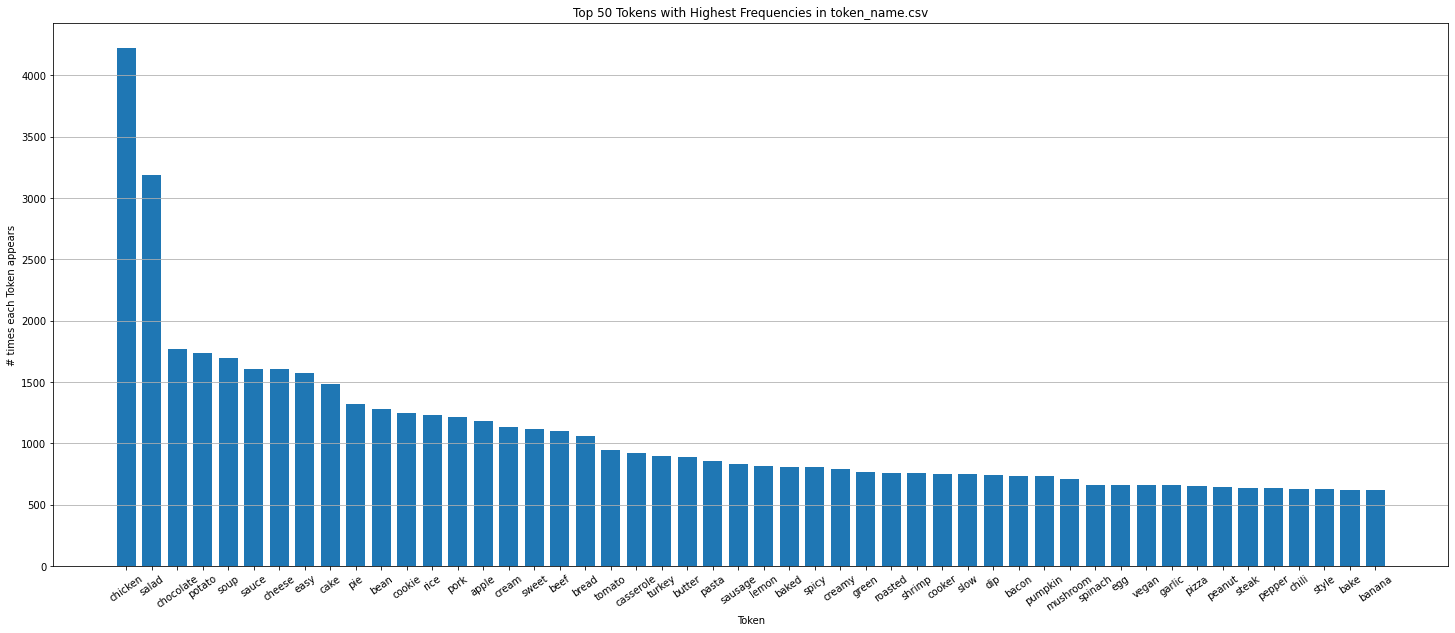

In [ ]:
csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/token_name.csv'
csv_token_name = pd.read_csv(csv_path)

# count number of (1)recipe, (2)unique token, (3)token/word
# list_remain_name is a list copy of csv_token_name, and will be filtered.
dict_token = {}
count_token = 0
list_remain_name = []
for i, row in csv_token_name.iterrows():
  remain_name = []
  for word in row['token_name'].strip("[]").split(', '):
    word = word[1:-1]
    if (word in dict_token):
      dict_token[word] += 1
    else:
      dict_token[word] = 1
    count_token += 1
    remain_name.append(word)
  list_remain_name.append([remain_name, row['index']])
  if i % 10000 == 0:
    print('Reading and copying:', i, '~', min(i+10000, csv_token_name.shape[0]-1))
print('# of Recipe:\t', len(list_remain_name))
print('# of Word:\t', count_token)
print('unique Tokens:\t', len(dict_token), end='\n\n')

# visualize top 50 tokens with highest frequencies
dict_top_token = dict(sorted(dict_token.items(), key=operator.itemgetter(1), reverse=True)[:50])
f0 = plt.figure(num=0, figsize=(25,10))
f0.patch.set_facecolor('white')
plt.bar(dict_top_token.keys(), dict_top_token.values(), width=0.75)
plt.xticks(rotation=35)
plt.grid(axis='y')
plt.xlabel('Token')
plt.ylabel('# times each Token appears')
plt.title('Top 50 Tokens with Highest Frequencies in token_name.csv')
f0.show()

# remove infrequent tokens that appear only 1 time in token_name.csv
# (if the tokenized name of a recipe is empty, the recipe will be removed)
list_infreq_token = [key for (key,value) in dict_token.items() if value<=1]
print('infrequent Tokens:\t', len(list_infreq_token))
count_token = 0                               # number of words remaining
count_removed_token = 0                       # number of words removed
                                          ### (sum to original # words)
count_removed = 0                             # number of rows removed
                                          ### (sum to original recipe)
list_token = []                               # dictionary of remaining tokens
                                          ### (sum to )
original_length = len(list_remain_name)
# for each recipe
i = 0
index = 0
while i < len(list_remain_name):
  # report every 1000 iterative steps
  if index % 1000 == 0:
    print('Removing infrequent tokens:', index, '~', min(index+1000, original_length-1))
  row = list_remain_name[i]
  name_list = row[0]
  name_keeper = name_list.copy()
  # for each word in a recipe
  for token in name_keeper:
    if token in list_infreq_token:
      count_removed_token += 1
      name_list.remove(token)
    else:
      count_token += 1
      if token not in list_token:
        list_token.append(token)
  i += 1
  index += 1
  # after looping through all words in a recipe
  if name_list == []:
    count_removed += 1
    print('!', row[1], name_keeper,'removed due to lack of common tokens.', sep='\t')
    list_remain_name.remove(row)
    i = i - 1
  #elif len(name_keeper) - 1 > len(name_list):
    #print(' ', row[1], name_keeper, '-->', name_list, sep='\t')   # print recipe that loses at least 2 tokens

print('# of Recipe:\t', len(list_remain_name), '(-' + str(count_removed) + ')')
print('# of Word:\t', count_token, '(-' + str(count_removed_token) + ')')
print('unique Tokens:\t', len(list_token), '(-' + str(len(dict_token)-len(list_token)) + ')', end='\n\n')

csv_filtered_token = pd.DataFrame(list_remain_name, columns=['filtered_token', 'index'])
print(csv_filtered_token)

csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/filtered_token.csv'
csv_filtered_token.to_csv(csv_path, index=False)

===================== D =====================

This section loads filtered_token.csv and saves 2 files (or optionally 2 pairs of 2 files):

(1) lda_tfidf.model (or optionally lda_glove.model), a Latent Dirichlet Allocation (LDA) model file

(2) topic_tfidf.csv (or optionally topic_glove.csv), a csv with 2 columns: topic_name, and index

The file(s) topic_tfidf.csv or(and) topic_glove.csv will be used as label look-up.

In [4]:
csv_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/filtered_token.csv'
csv_filtered_token = pd.read_csv(csv_path)

# count_token and list_token are used to debug gensim topic modeling and dictionary
list_filtered_token = []
count_token = 0
list_unique_token = []
for i, row in csv_filtered_token.iterrows():
  if i % 10000 == 0:
    print('Reading and copying:', i, '~', min(i+10000, csv_filtered_token.shape[0]-1))
  filtered_token = []
  for token in row['filtered_token'].strip("[]").split(', '):
    count_token += 1
    token = token[1:-1]
    if token not in list_unique_token:
      list_unique_token.append(token)
    filtered_token.append(token)
  list_filtered_token.append([filtered_token, row['index']])
print('# of Recipe:\t', len(list_filtered_token))
print('# of Word:\t', count_token)
print('unique Tokens:\t', len(list_unique_token))

Reading and copying: 0 ~ 10000
Reading and copying: 10000 ~ 20000
Reading and copying: 20000 ~ 30000
Reading and copying: 30000 ~ 40000
Reading and copying: 40000 ~ 46658
# of Recipe:	 46659
# of Word:	 169768
unique Tokens:	 4356


In [5]:
# number of sample to show
n_sample = 11

# isolate 'filtered_token' column from list_filtered_token
list_only_token = []
for row in list_filtered_token:
  list_only_token.append(row[0])
for i in range(n_sample):
  print('\t', list_only_token[i])
print('\t', '...', end='\n\n')

# create a gensim dictionary
id_to_token = corpora.Dictionary(list_only_token)
print('gensim dictionary tokens:\t', len(id_to_token))
for i in range(n_sample):
  print('\t', i, id_to_token[i])
print('\t', '...', end='\n\n')

# create bag-of-words (BoW) representation 
corpus_bow = [id_to_token.doc2bow(token) for token in list_only_token]
print('gensim BoW recipe:\t', len(corpus_bow))
for i in range(n_sample):
  print('\t', corpus_bow[i])
print('\t', '...', end='\n\n')

# create TF-IDF representation using bag-of-words representation
tfidf = models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]
print('gensim TF-IDF recipe:\t', len(corpus_tfidf))
for i in range(n_sample):
  print('\t', corpus_tfidf[i])
print('\t', '...')

	 ['wheat', 'pita', 'bread']
	 ['baked', 'mac', 'cheese']
	 ['blonde', 'bobbie']
	 ['egg', 'butter']
	 ['beer', 'pizza']
	 ['microwave', 'lemon', 'curd']
	 ['apple', 'chutney']
	 ['frank', 'spicy', 'alabama', 'onion', 'beer', 'chili']
	 ['simple', 'tasty', 'chinese', 'steamed', 'bun']
	 ['italian', 'sausage', 'delight']
	 ['david', 'slow', 'cooker', 'brisket']
	 ...

gensim dictionary tokens:	 4356
	 0 bread
	 1 pita
	 2 wheat
	 3 baked
	 4 cheese
	 5 mac
	 6 blonde
	 7 bobbie
	 8 butter
	 9 egg
	 10 beer
	 ...

gensim BoW recipe:	 46659
	 [(0, 1), (1, 1), (2, 1)]
	 [(3, 1), (4, 1), (5, 1)]
	 [(6, 1), (7, 1)]
	 [(8, 1), (9, 1)]
	 [(10, 1), (11, 1)]
	 [(12, 1), (13, 1), (14, 1)]
	 [(15, 1), (16, 1)]
	 [(10, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1)]
	 [(22, 1), (23, 1), (24, 1), (25, 1), (26, 1)]
	 [(27, 1), (28, 1), (29, 1)]
	 [(30, 1), (31, 1), (32, 1), (33, 1)]
	 ...

gensim TF-IDF recipe:	 46659
	 [(0, 0.40377117632800263), (1, 0.6962950508078992), (2, 0.593415570563434)]
	 [(

In [8]:
# training hyperparameters
chunksize = len(list_filtered_token)
iterations = 5000
num_topics = 250      # based on general categorization of allrecipes.com
passes = 300
eval_every = None

# train and save a LDA model using TF-IDF representation
# (do not run if (lda_tfidf.model) already exists, this sub-section takes 50~60 minutes to run.)
model_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/lda_tfidf.model'
print('Training the LDA model using TF-IDF representation ...')
start_time = time.time()
lda_model_tfidf = gensim.models.LdaModel(corpus=corpus_tfidf, 
                                         id2word=id_to_token,
                                         chunksize=chunksize,
                                         iterations=iterations,
                                         num_topics=num_topics,
                                         passes=passes,
                                         eval_every=eval_every)
end_time = time.time()
print('Finished in', round(end_time-start_time, 2), 'seconds.')
lda_model_tfidf.save(model_path)

2020-11-19 04:49:27,366 : INFO : using symmetric alpha at 0.004
2020-11-19 04:49:27,372 : INFO : using symmetric eta at 0.004
2020-11-19 04:49:27,376 : INFO : using serial LDA version on this node
2020-11-19 04:49:27,549 : INFO : running online (multi-pass) LDA training, 250 topics, 300 passes over the supplied corpus of 46659 documents, updating model once every 46659 documents, evaluating perplexity every 0 documents, iterating 5000x with a convergence threshold of 0.001000


Training the LDA model using TF-IDF representation ...


2020-11-19 04:49:28,968 : INFO : PROGRESS: pass 0, at document #46659/46659
2020-11-19 04:49:42,305 : INFO : topic #101 (0.004): 0.024*"turkey" + 0.022*"creamy" + 0.013*"salad" + 0.013*"lemon" + 0.012*"banana" + 0.011*"breakfast" + 0.010*"smoothie" + 0.010*"meatball" + 0.010*"pineapple" + 0.009*"berry"
2020-11-19 04:49:42,306 : INFO : topic #0 (0.004): 0.025*"rice" + 0.020*"chicken" + 0.013*"egg" + 0.013*"easy" + 0.012*"salad" + 0.011*"noodle" + 0.010*"cheese" + 0.010*"beef" + 0.009*"bake" + 0.009*"cottage"
2020-11-19 04:49:42,311 : INFO : topic #54 (0.004): 0.017*"chicken" + 0.013*"stuffed" + 0.012*"pudding" + 0.012*"bread" + 0.011*"thai" + 0.011*"cake" + 0.011*"salad" + 0.010*"caramel" + 0.010*"easy" + 0.009*"sauce"
2020-11-19 04:49:42,313 : INFO : topic #150 (0.004): 0.018*"salad" + 0.015*"sugar" + 0.013*"bean" + 0.012*"chicken" + 0.012*"chef" + 0.011*"john" + 0.011*"broccoli" + 0.011*"sweet" + 0.010*"toast" + 0.009*"bake"
2020-11-19 04:49:42,314 : INFO : topic #190 (0.004): 0.027*"

Finished in 3456.07 seconds.


2020-11-19 05:47:03,670 : INFO : saved /content/drive/My Drive/Colab Notebooks/Project_REScipe/data/lda_tfidf.model


In [9]:
# load the trained LDA TF-IDF model saved in the google drive
model_path = '/'.join(XLSX_PATH.split(sep='/')[:-1]) + '/lda_tfidf.model'
lda_model_tfidf = models.ldamodel.LdaModel.load(model_path)
n_sample = 20
print('Sample Topics of gensim LDA model using TF-IDF:')
for i in range(n_sample):
  print(lda_model_tfidf.print_topics()[i])
print('...', end='\n\n')

2020-11-19 05:49:37,952 : INFO : loading LdaModel object from /content/drive/My Drive/Colab Notebooks/Project_REScipe/data/lda_tfidf.model
2020-11-19 05:49:37,962 : INFO : loading expElogbeta from /content/drive/My Drive/Colab Notebooks/Project_REScipe/data/lda_tfidf.model.expElogbeta.npy with mmap=None
2020-11-19 05:49:37,978 : INFO : setting ignored attribute id2word to None
2020-11-19 05:49:37,979 : INFO : setting ignored attribute dispatcher to None
2020-11-19 05:49:37,980 : INFO : setting ignored attribute state to None
2020-11-19 05:49:37,983 : INFO : loaded /content/drive/My Drive/Colab Notebooks/Project_REScipe/data/lda_tfidf.model
2020-11-19 05:49:37,985 : INFO : loading LdaState object from /content/drive/My Drive/Colab Notebooks/Project_REScipe/data/lda_tfidf.model.state
2020-11-19 05:49:38,011 : INFO : loaded /content/drive/My Drive/Colab Notebooks/Project_REScipe/data/lda_tfidf.model.state
2020-11-19 05:49:38,022 : INFO : topic #200 (0.004): 0.293*"mom" + 0.277*"meat" + 0.

Sample Topics of gensim LDA model using TF-IDF:
(200, '0.293*"mom" + 0.277*"meat" + 0.085*"snow" + 0.070*"packet" + 0.033*"pie" + 0.029*"pea" + 0.022*"barilla" + 0.021*"sauce" + 0.010*"kiki" + 0.009*"easy"')
(16, '0.162*"day" + 0.109*"twice" + 0.080*"game" + 0.080*"champagne" + 0.078*"braised" + 0.067*"valentine" + 0.047*"shank" + 0.046*"bavarian" + 0.034*"lite" + 0.025*"slushie"')
(207, '0.307*"mexican" + 0.279*"spaghetti" + 0.028*"jerk" + 0.027*"casserole" + 0.024*"sauce" + 0.022*"salisbury" + 0.020*"rice" + 0.019*"chicken" + 0.018*"fluff" + 0.017*"style"')
(180, '0.188*"simply" + 0.168*"way" + 0.080*"quince" + 0.057*"acai" + 0.037*"5-ingredient" + 0.033*"shoot" + 0.029*"gift" + 0.026*"jessica" + 0.021*"shred" + 0.019*"gratinee"')
(237, '0.390*"biscuit" + 0.172*"appetizer" + 0.132*"blt" + 0.033*"nanaimo" + 0.020*"sausage" + 0.017*"cheese" + 0.017*"ukrainian" + 0.016*"feather" + 0.016*"cure" + 0.016*"chick"')
(85, '0.428*"italian" + 0.087*"sausage" + 0.054*"style" + 0.052*"crusted" + 

2020-11-19 05:49:38,222 : INFO : topic #152 (0.004): 0.416*"raspberry" + 0.123*"s'more" + 0.052*"campfire" + 0.046*"sundae" + 0.027*"lazy" + 0.023*"pie" + 0.022*"mild" + 0.020*"vide" + 0.020*"sou" + 0.016*"eyeball"
2020-11-19 05:49:38,224 : INFO : topic #32 (0.004): 0.246*"mix" + 0.103*"caesar" + 0.063*"minestrone" + 0.062*"poached" + 0.057*"canadian" + 0.056*"oyster" + 0.054*"chex" + 0.047*"refresh" + 0.047*"whiskey" + 0.046*"blossom"
2020-11-19 05:49:38,225 : INFO : topic #163 (0.004): 0.312*"mint" + 0.081*"parsley" + 0.055*"drunken" + 0.043*"breadstick" + 0.043*"broccolini" + 0.036*"ragout" + 0.036*"julep" + 0.027*"pavlovum" + 0.025*"spooky" + 0.023*"happy"
2020-11-19 05:49:38,226 : INFO : topic #99 (0.004): 0.417*"fresh" + 0.126*"traditional" + 0.122*"snack" + 0.094*"slider" + 0.028*"poutine" + 0.016*"tomato" + 0.013*"strawberry" + 0.012*"pie" + 0.011*"boursin" + 0.010*"salad"
2020-11-19 05:49:38,227 : INFO : topic #14 (0.004): 0.354*"savory" + 0.241*"jalapeno" + 0.067*"tequila" + 

(3, '0.305*"crab" + 0.237*"vinaigrette" + 0.151*"tilapia" + 0.049*"salad" + 0.027*"hoppin" + 0.026*"cake" + 0.021*"rangoon" + 0.011*"creamy" + 0.010*"dip" + 0.010*"lemon"')
(108, '0.202*"russian" + 0.099*"polish" + 0.068*"romaine" + 0.061*"eastern" + 0.052*"pickled" + 0.052*"middle" + 0.050*"croissant" + 0.045*"donut" + 0.041*"salad" + 0.027*"hero"')
(94, '0.543*"baked" + 0.137*"oven" + 0.054*"potato" + 0.043*"chicken" + 0.037*"masala" + 0.025*"easy" + 0.018*"bean" + 0.018*"tikka" + 0.015*"casserole" + 0.015*"roasted"')
(158, '0.128*"shepherd" + 0.127*"twist" + 0.127*"special" + 0.110*"minute" + 0.073*"pie" + 0.062*"restaurant" + 0.052*"cantaloupe" + 0.028*"tiffany" + 0.026*"style" + 0.022*"faux"')
(213, '0.236*"eggnog" + 0.165*"leftover" + 0.083*"batter" + 0.041*"morel" + 0.033*"tempura" + 0.031*"turkey" + 0.030*"substitute" + 0.024*"pittsburgh" + 0.021*"drunk" + 0.019*"pancit"')
(86, '0.143*"leg" + 0.094*"icebox" + 0.065*"cran" + 0.058*"lamb" + 0.056*"cloud" + 0.050*"panko" + 0.036*"

2020-11-19 05:49:38,434 : INFO : topic #34 (0.004): 0.243*"sour" + 0.174*"cup" + 0.086*"cream" + 0.078*"dark" + 0.069*"sweet" + 0.041*"saucy" + 0.034*"tostada" + 0.028*"chocolate" + 0.025*"anise" + 0.014*"dave"
2020-11-19 05:49:38,436 : INFO : topic #169 (0.004): 0.464*"skillet" + 0.119*"bark" + 0.086*"vinegar" + 0.032*"chicken" + 0.025*"potato" + 0.022*"fresco" + 0.020*"buffet" + 0.020*"sausage" + 0.019*"easy" + 0.018*"rice"
2020-11-19 05:49:38,437 : INFO : topic #235 (0.004): 0.411*"glazed" + 0.291*"square" + 0.048*"marzetti" + 0.043*"crazy" + 0.029*"apple" + 0.018*"lemon" + 0.015*"sweet" + 0.008*"potato" + 0.008*"spicy" + 0.008*"spaghettini"
2020-11-19 05:49:38,438 : INFO : topic #89 (0.004): 0.292*"marinated" + 0.157*"tuscan" + 0.119*"dough" + 0.035*"freezer" + 0.028*"steak" + 0.022*"creamsicle" + 0.020*"north" + 0.020*"finnish" + 0.019*"grill" + 0.016*"chicken"
2020-11-19 05:49:38,439 : INFO : topic #179 (0.004): 0.274*"favorite" + 0.124*"rigatoni" + 0.049*"halloumi" + 0.040*"san"

(179, '0.274*"favorite" + 0.124*"rigatoni" + 0.049*"halloumi" + 0.040*"san" + 0.035*"family" + 0.027*"cristo" + 0.024*"pacific" + 0.023*"monte" + 0.021*"size" + 0.021*"francisco"')
(71, '0.167*"sea" + 0.117*"high" + 0.112*"friendly" + 0.109*"nectarine" + 0.065*"valley" + 0.053*"salt" + 0.040*"hide" + 0.034*"cinco" + 0.025*"vermicelli" + 0.019*"mayo"')
(72, '0.259*"rosemary" + 0.129*"crescent" + 0.124*"juice" + 0.117*"pressure" + 0.068*"cooker" + 0.022*"slushy" + 0.021*"chicken" + 0.018*"4-ingredient" + 0.015*"potato" + 0.015*"laura"')
(169, '0.464*"skillet" + 0.119*"bark" + 0.086*"vinegar" + 0.032*"chicken" + 0.025*"potato" + 0.022*"fresco" + 0.020*"buffet" + 0.020*"sausage" + 0.019*"easy" + 0.018*"rice"')
(126, '0.515*"almond" + 0.202*"best" + 0.023*"chocolate" + 0.022*"cookie" + 0.020*"hole" + 0.019*"marzipan" + 0.019*"ethiopian" + 0.012*"murgh" + 0.012*"cake" + 0.011*"grouper"')
...

